In [1]:
import sys

sys.path.append('..')

In [2]:
from filter_clinvar_xml import filter_xml, pprint, iterate_cvs_from_xml

In [3]:
import pandas as pd
from cmat.clinvar_xml_io import *
from cmat.clinvar_xml_io.xml_parsing import *

In [31]:
pd.set_option('display.max_rows', 500)

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
full_path = '/home/april/projects/opentargets/clinvar.xml.gz'
sample_path = '/home/april/projects/opentargets/clinvar-sample.xml.gz'

In [47]:
clinvar_path = full_path

In [52]:
# format='%Y-%m-%d' but only usually...
dates = []
for raw_cvs_xml in iterate_cvs_from_xml(clinvar_path):
    # Get submitted dates for SCVs
    scvs = find_elements(raw_cvs_xml, './ClinVarAssertion/ClinVarSubmissionID')
    submitter_dates = [scv.attrib.get('submitterDate') for scv in scvs]
    submitter_dates = [pd.to_datetime(d) for d in submitter_dates if d]
    if not submitter_dates:
        submitter_dates = [pd.NaT]
    
    # Get created date for RCV
    rcv = find_mandatory_unique_element(raw_cvs_xml, './ReferenceClinVarAssertion')
    record = ClinVarRecord(rcv)
    created_date = pd.to_datetime(record.rcv.attrib['DateCreated']) if record.rcv.attrib['DateCreated'] else None
    
    dates.append((record.accession, created_date, min(submitter_dates), max(submitter_dates)))

In [53]:
df = pd.DataFrame(dates, columns=('accession', 'created date', 'min submitted date', 'max submitted date'))
df['min sub to created'] = df['created date'] - df['min submitted date']

In [54]:
df.head()

,accession,created date,min submitted date,max submitted date,min sub to created
0,RCV000000009,2013-04-04,2017-12-11,2017-12-11,-1712 days
1,RCV000000010,2013-04-04,2015-08-10,2015-08-10,-858 days
2,RCV000000012,2013-04-04,2017-01-26,2020-11-14,-1393 days
3,RCV000000013,2013-04-04,2017-01-26,2017-01-26,-1393 days
4,RCV000000016,2013-04-04,2019-01-31,2019-01-31,-2128 days


(array([2.570000e+02, 4.640000e+02, 7.420000e+02, 3.060000e+02,
        4.250000e+02, 7.700000e+02, 1.435000e+03, 7.220000e+02,
        2.651000e+03, 1.603000e+03, 2.439000e+03, 3.765000e+03,
        8.581000e+03, 5.939000e+03, 7.861000e+03, 1.538800e+04,
        5.940000e+03, 2.901500e+04, 3.701100e+04, 8.410000e+03,
        2.972100e+04, 8.663000e+03, 3.970300e+04, 1.373390e+05,
        2.831100e+04, 1.034010e+05, 1.084600e+04, 2.860400e+04,
        2.023010e+05, 1.424000e+04, 4.113100e+04, 3.831680e+05,
        2.590000e+04, 4.611200e+04, 1.548448e+06, 1.737300e+05,
        7.490500e+04, 6.356000e+03, 1.130400e+04, 1.665000e+03,
        2.845000e+03, 8.990000e+02, 1.396000e+03, 4.400000e+02,
        6.160000e+02, 5.770000e+02, 5.920000e+02, 1.570000e+02,
        2.330000e+02, 1.112000e+03, 1.009000e+03, 1.320000e+02,
        2.250000e+02, 6.200000e+01, 9.000000e+01, 7.700000e+01,
        8.500000e+01, 3.500000e+01, 2.100000e+01, 7.800000e+01,
        2.300000e+01, 1.800000e+01, 1.30

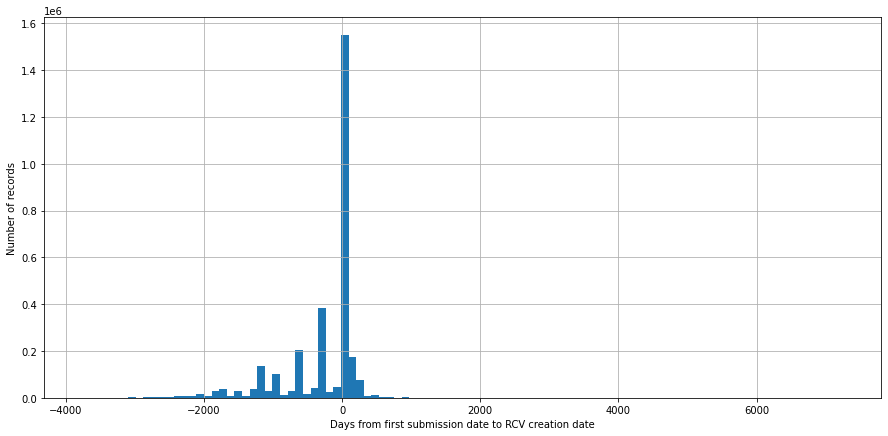

In [66]:
plt.figure(figsize=(15,7))
plt.xlabel('Days from first submission date to RCV creation date')
plt.ylabel('Number of records')
plt.grid()
plt.hist(df['min sub to created'].dt.days, bins=100)

Negative values means RCV creation precedes first submission (e.g. maybe a submission was withdrawn?)

In [67]:
def percent_within_days(num_days):
    return len(df[abs(df['min sub to created']) < pd.Timedelta(num_days, unit='days')]) / len(df) * 100

In [68]:
percent_within_days(365)

74.02446764274615

In [70]:
percent_within_days(120)

54.9929428427425